# Output feedback control for the harmonic oscillator
The harmonic oscillator is a useful model for systems that have a dominating resonance frequency with no, or very little damping. An example of such systems is the sideway movement of a container hanging from a gantry crane moving containers on and off ships.
![title](gantry-crane.png)
<font size="2">by Tosaka, from Wikimedia.org</font>

Consider a container of mass $m=10^4$ kg, hanging from a wire of length $l=40$ m. We can control the system by applying an acceleration $u$ of the cart on top of the crane. The ODE describing the dynamics of the container is obtained by considering a reference frame fixed in the cart 
$$ ml^2 \ddot{\theta} = -lmg\sin\theta + lm\cos\theta u + l\cos\theta w,$$
where $\theta$ is the angle of the wires to the vertical, and $w$ is a disturbance force from wind blowing on the container. The small-angle approximation $\sin\theta \approx \theta$ works well in this case, giving the model
$$\ddot{\theta} = -\frac{g}{l}\theta + \frac{1}{l}u + \frac{1}{lm}w.$$
Write $y=\theta$ and the model in the s-domain becomes
$$ Y(s) = \frac{1}{s^2 + \omega^2}\Big(bU(s) + kW(s)\big),$$
where $\omega^2 = \frac{g}{l}= \frac{9.8}{40} \approx 0.25$ and $b=1/l= 0.025$ and $k=1/(lm) = 2.5\times 10^{-5}$ 

The system can be written on state-space form as
\begin{align}
\dot{x} &= \underbrace{\begin{bmatrix} 0 & -\omega^2\\1 & 0 \end{bmatrix}}_{A}x + \underbrace{\begin{bmatrix}1\\0\end{bmatrix}}_{B}bu + \begin{bmatrix}1\\0\end{bmatrix}kw\\
y &= \underbrace{\begin{bmatrix} 0 & 1 \end{bmatrix}}_{C}x
\end{align}

## Discrete-time state-space model
The discrete-time state-space model using a sampling period $h$ is
\begin{align}
x(k+1) &= \Phi(h)x(k) + \Gamma(h)u + \Gamma(h)v\\
y(k) &= Cx(k)
\end{align}
where
$$ \Phi(h) = \mathrm{e}^{Ah} = \begin{bmatrix} \cos(h\omega) & -\omega\sin(h\omega)\\\frac{1}{\omega}\sin(h\omega) & \cos(h\omega) \end{bmatrix}$$
and
$$ \Gamma(h) = \int_0^h \mathrm{e}^{As}B ds = \begin{bmatrix} \frac{1}{\omega}\sin(h\omega)\\\frac{1}{\omega^2} \big(1-\cos(h\omega)\big) \end{bmatrix}.$$
### Verification by symbolic computation

In [18]:
import numpy as np
import sympy as sy
sy.init_printing(use_latex='mathjax', order='lex')

h,omega = sy.symbols('h,omega', real=True, positive=True)
A = sy.Matrix([[0,-omega**2], [1,0]])
B = sy.Matrix([[1],[0]])
Phi = sy.simplify(sy.exp(A*h).rewrite(sy.sin))
Phi

⎡cos(h⋅ω)  -ω⋅sin(h⋅ω)⎤
⎢                     ⎥
⎢sin(h⋅ω)             ⎥
⎢────────   cos(h⋅ω)  ⎥
⎣   ω                 ⎦

In [17]:
s = sy.symbols('s',real=True, positive=True)
Gamma =  sy.simplify(sy.integrate(sy.exp(A*s)*B, (s, 0, h)).rewrite(sy.cos))
Gamma

⎡  sin(h⋅ω)   ⎤
⎢  ────────   ⎥
⎢     ω       ⎥
⎢             ⎥
⎢-cos(h⋅ω) + 1⎥
⎢─────────────⎥
⎢       2     ⎥
⎣      ω      ⎦

### Choosing the sampling ratio $h$
We may use the rule-of-thumb $\omega h \approx 0.2\, \text{to} \, 0.6$ for choosing the sampling period. For our specific case we also have $\omega^2 = 0.25$. Let's choose $\omega h = \pi/6 \approx 0.53$, so that $\cos(h\omega) = \frac{\sqrt{3}}{2} \approx 0.866$ and $\sin(h\omega) = 0.5.$ This gives the discrete-time system (ignoring the disturbance for now)
\begin{align}
    x(k+1) &= \begin{bmatrix} \frac{\sqrt{3}}{2} & -0.25 \\ 1 & \frac{\sqrt{3}}{2} \end{bmatrix} + \begin{bmatrix} 1\\4-2\sqrt{3}\end{bmatrix}0.025u(k)\\
    y(k) &= \begin{bmatrix} 0 & 1\end{bmatrix} x
 \end{align}

In [20]:
omegaval = 0.5
hval = np.pi/6/omegaval
Phi_np = np.array(Phi.subs({h:hval, omega:omegaval})).astype(np.float64)
Phi_np

array([[ 0.8660254, -0.25     ],
       [ 1.       ,  0.8660254]])

In [23]:
Gamma_np = np.array(Gamma.subs({h:hval, omega:omegaval})).astype(np.float64)
Gamma_np

array([[1.        ],
       [0.53589838]])

In [24]:
4-2*np.sqrt(3)

0.5358983848622456

## Reachability 
The controllability matrix for this second order system becomes
$$ W_c = \begin{bmatrix} \Gamma & \Phi\Gamma \end{bmatrix} = \begin{bmatrix} 1 & 0.732\\ 0.536 & 1.464 \end{bmatrix}, $$
with determinant
$$\det W_c = 1.072 \neq 0.$$

In [36]:
Wc_n = np.hstack((Gamma_np, np.dot(Phi_np,Gamma_np)))
Wc_n

array([[1.        , 0.73205081],
       [0.53589838, 1.46410162]])

In [37]:
np.linalg.det(Wc_n)

1.0717967697244903

## State feedback
Introducing the state-feedback control law
$$ u = -l_1x_1 - l_2 x_2 + l_0y_{ref} = -Lx + l_0y_{ref}$$
gives the closed-loop state-space system
\begin{align}
x(k+1) &= \Phi x(k) +\Gamma\big(-Lx(k) + l_0y_{ref}(k)\big) + \Gamma v(k) = \left( \Phi - \Gamma L \right) x(k) + l_0\Gamma y_{ref}(k) + \Gamma v(k)\\
y(k) &= C x(k),
\end{align}
where
$$ \Gamma L = \begin{bmatrix} 1\\0.536\end{bmatrix}\begin{bmatrix}l_1 & l_2\end{bmatrix} = \begin{bmatrix} l_1 & l_2\\0.536 l_1 & 0.536 l_2 \end{bmatrix} $$
and
$$ \Phi - \Gamma L = \begin{bmatrix} 0.866 & -0.25 \\ 1 & 0.866\end{bmatrix} - \begin{bmatrix} l_1 & l_2\\0.536 l_1 & 0.536 l_2 \end{bmatrix} = \begin{bmatrix} 0.866-l_1 & -0.25-l_2\\ 1 - 0.536l_1 & 0.866 - 0.536l_2\end{bmatrix}$$

In [40]:
l1,l2 = sy.symbols('l1,l2')
L = sy.Matrix([[l1, l2]])
Phi_c=Phi.subs({h:hval, omega:omegaval}) - Gamma.subs({h:hval, omega:omegaval})*L

The characteristic polynomial of the closed-loop system is given by
\begin{align}
\det \left( zI - (\Phi-\Gamma L) \right) &= \det \left( \begin{bmatrix} z & 0\\0 & z \end{bmatrix} - \begin{bmatrix} 0.866-l_1 & -0.25-l_2\\ 1 - 0.536l_1 & 0.866 - 0.536l_2\end{bmatrix} \right)\\
&= \det \begin{bmatrix} z-0.866+l_1 & -0.25+l_2\\0.536l_1-1 & z-0.866+0.536l_2\end{bmatrix}\\
&= z^2 + (l_1+0.536l_2 -1.732) z + (1 -l_1 +0.536l_2)
\end{align}

In [42]:
z = sy.symbols('z')
zIminPhic = z*sy.eye(2) - Phi_c
zIminPhic

⎡1.0⋅l₁ + z - 0.866025403784439                 1.0⋅l₂ + 0.25                ⎤
⎢                                                                            ⎥
⎣  0.535898384862245⋅l₁ - 1.0    0.535898384862245⋅l₂ + z - 0.866025403784439⎦

In [41]:
ch_poly = sy.Poly(zIminPhic.det(), z)
ch_poly.as_expr()

                                         2                                    
-- -1.0⋅l₁ + 0.535898384862245⋅l₂ + 1.0⋅z  + z⋅(1.0⋅l₁ + 0.535898384862245⋅l₂ 

                         
- 1.73205080756888) + 1.0

### Desired closed-loop characteristic polynomial
Here we will aim for a pair of closed-loop poles that are critically damped, and about as fast as the plant poles. 
are interested in designing a deadbeat controller, so the desired closed-loop poles are
$$ p_1 = 0, \qquad p_2=0,$$
and the desired characteristic polynomial is 
$$ A_c(z) = (z-p_1)(z-p_2) = z^2. $$
In the same spirit as when designing an RST controller using the polynomial approach, we set the calculated characteristic polynomial - obtained when introducing the linear state feedback- equal to the desired characteristic polynomial.
\begin{align}
z^1: \qquad l_1\frac{h^2}{2} + l_2h -2 &= 0\\
z^0: \qquad l_1\frac{h^2}{2} - l_2h+1 &= 0
\end{align}
which can be written as the system of equations
$$ \underbrace{\begin{bmatrix} \frac{h^2}{2} & h\\\frac{h^2}{2} & -h \end{bmatrix}}_{M} \underbrace{\begin{bmatrix} l_1\\l_2\end{bmatrix}}_{L^T} = \underbrace{\begin{bmatrix}2\\-1\end{bmatrix}}_{b} $$
with solution given by 


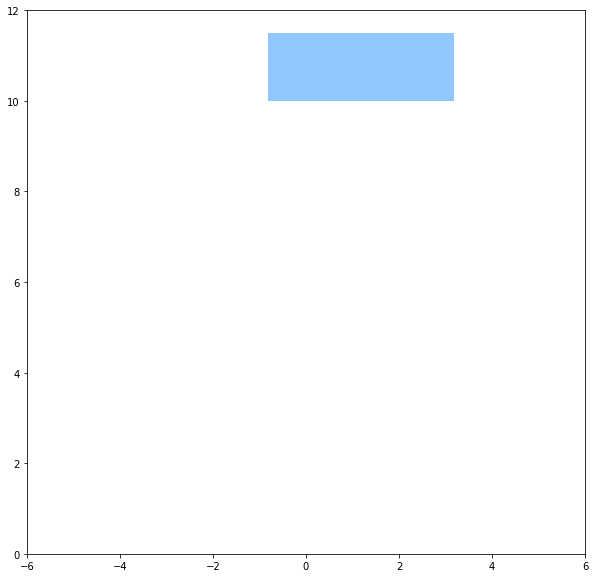

In [60]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.patches import Rectangle

plt.style.use('seaborn-pastel')

NN = 100
tvec = hval*np.arange(NN)
th = np.sin(0.2*tvec)
z = np.sin(0.1*tvec)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(xlim=(-6, 6), ylim=(0, 12))
yc = 10
cartwidth = 4
cartheight = 1.5
rect = Rectangle((z[0]-cartwidth/2, yc), width=cartwidth, height=cartheight)

ax.add_patch(rect)
def init():
    return rect,
def animate(i):
    if i<NN :
        x = z[i]
        rect.set_x(x)
    return rect,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=NN, interval=int(hval*100), blit=True)


anim.save('sine_wave.gif', writer='imagemagick')
plt.show()

In [59]:
HTML(anim.to_html5_video())

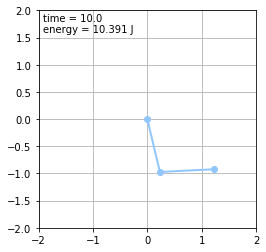

In [66]:
"""
General Numerical Solver for the 1D Time-Dependent Schrodinger's equation.

adapted from code at http://matplotlib.sourceforge.net/examples/animation/double_pendulum_animated.py

Double pendulum formula translated from the C code at
http://www.physics.usyd.edu.au/~wheat/dpend_html/solve_dpend.c

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""

from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

class DoublePendulum:
    """Double Pendulum Class

    init_state is [theta1, omega1, theta2, omega2] in degrees,
    where theta1, omega1 is the angular position and velocity of the first
    pendulum arm, and theta2, omega2 is that of the second pendulum arm
    """
    def __init__(self,
                 init_state = [120, 0, -20, 0],
                 L1=1.0,  # length of pendulum 1 in m
                 L2=1.0,  # length of pendulum 2 in m
                 M1=1.0,  # mass of pendulum 1 in kg
                 M2=1.0,  # mass of pendulum 2 in kg
                 G=9.8,  # acceleration due to gravity, in m/s^2
                 origin=(0, 0)): 
        self.init_state = np.asarray(init_state, dtype='float')
        self.params = (L1, L2, M1, M2, G)
        self.origin = origin
        self.time_elapsed = 0

        self.state = self.init_state * np.pi / 180.
    
    def position(self):
        """compute the current x,y positions of the pendulum arms"""
        (L1, L2, M1, M2, G) = self.params

        x = np.cumsum([self.origin[0],
                       L1 * sin(self.state[0]),
                       L2 * sin(self.state[2])])
        y = np.cumsum([self.origin[1],
                       -L1 * cos(self.state[0]),
                       -L2 * cos(self.state[2])])
        return (x, y)

    def energy(self):
        """compute the energy of the current state"""
        (L1, L2, M1, M2, G) = self.params

        x = np.cumsum([L1 * sin(self.state[0]),
                       L2 * sin(self.state[2])])
        y = np.cumsum([-L1 * cos(self.state[0]),
                       -L2 * cos(self.state[2])])
        vx = np.cumsum([L1 * self.state[1] * cos(self.state[0]),
                        L2 * self.state[3] * cos(self.state[2])])
        vy = np.cumsum([L1 * self.state[1] * sin(self.state[0]),
                        L2 * self.state[3] * sin(self.state[2])])

        U = G * (M1 * y[0] + M2 * y[1])
        K = 0.5 * (M1 * np.dot(vx, vx) + M2 * np.dot(vy, vy))

        return U + K

    def dstate_dt(self, state, t):
        """compute the derivative of the given state"""
        (M1, M2, L1, L2, G) = self.params

        dydx = np.zeros_like(state)
        dydx[0] = state[1]
        dydx[2] = state[3]

        cos_delta = cos(state[2] - state[0])
        sin_delta = sin(state[2] - state[0])

        den1 = (M1 + M2) * L1 - M2 * L1 * cos_delta * cos_delta
        dydx[1] = (M2 * L1 * state[1] * state[1] * sin_delta * cos_delta
                   + M2 * G * sin(state[2]) * cos_delta
                   + M2 * L2 * state[3] * state[3] * sin_delta
                   - (M1 + M2) * G * sin(state[0])) / den1

        den2 = (L2 / L1) * den1
        dydx[3] = (-M2 * L2 * state[3] * state[3] * sin_delta * cos_delta
                   + (M1 + M2) * G * sin(state[0]) * cos_delta
                   - (M1 + M2) * L1 * state[1] * state[1] * sin_delta
                   - (M1 + M2) * G * sin(state[2])) / den2
        
        return dydx

    def step(self, dt):
        """execute one time step of length dt and update state"""
        self.state = integrate.odeint(self.dstate_dt, self.state, [0, dt])[1]
        self.time_elapsed += dt

#------------------------------------------------------------
# set up initial state and global variables
pendulum = DoublePendulum([180., 0.0, -20., 0.0])
dt = 1./30 # 30 fps

#------------------------------------------------------------
# set up figure and animation
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
energy_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)

def init():
    """initialize animation"""
    line.set_data([], [])
    time_text.set_text('')
    energy_text.set_text('')
    return line, time_text, energy_text

def animate(i):
    """perform animation step"""
    global pendulum, dt
    pendulum.step(dt)
    
    line.set_data(*pendulum.position())
    time_text.set_text('time = %.1f' % pendulum.time_elapsed)
    energy_text.set_text('energy = %.3f J' % pendulum.energy())
    return line, time_text, energy_text

# choose the interval based on dt and the time to animate one step
from time import time
t0 = time()
animate(0)
t1 = time()
interval = 1000 * dt - (t1 - t0)

ani = animation.FuncAnimation(fig, animate, frames=300,
                              interval=interval, blit=True, init_func=init)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
ani.save('double_pendulum.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

In [67]:
HTML(ani.to_html5_video())

$$L^T = M^{-1}b = \frac{1}{-h^3} \begin{bmatrix} -h & -h\\-\frac{h^2}{2} & \frac{h^2}{2} \end{bmatrix} \begin{bmatrix} 2\\-1 \end{bmatrix}$$

$$ = -\frac{1}{h^3} \begin{bmatrix} -2h+h\\-h^2-\frac{h^2}{2}\end{bmatrix} = \begin{bmatrix} \frac{1}{h^2}\\\frac{3}{2h} \end{bmatrix} $$
### Verification by symbolic calculation

In [8]:
des_ch_poly = sy.Poly(z*z, z)
dioph_eqn = ch_poly - des_ch_poly
sol = sy.solve(dioph_eqn.coeffs(), (l1,l2))
sol

⎧    1        3 ⎫
⎪l₁: ──, l₂: ───⎪
⎨     2      2⋅h⎬
⎪    h          ⎪
⎩               ⎭

In the system of equations $ML^T=b$ above, note that the matrix $M$ can be written
$$ M = \begin{bmatrix} \frac{h^2}{2} & h\\\frac{h^2}{2} & -h \end{bmatrix} = \begin{bmatrix}1 & 0\\-2 & 1\end{bmatrix}\underbrace{\begin{bmatrix} \frac{h^2}{2} & h \\ \frac{3h^2}{2} & h\end{bmatrix}}_{W_c^T}, $$
so $M$ will be invertible if and only if $\det W_c^T = \det W_c \neq 0$.

## The resulting closed-loop system
So, we have found the control law 
$$ u(k) = -Lx(k) + l_0y_{ref}(k) = -\begin{bmatrix} \frac{1}{h^2} & \frac{3}{2h} \end{bmatrix}x(k) + l_0 y_{ref}(k)$$
which gives a closed-loop system with poles in the origin, i.e. deadbeat control. The closed-loop system becomes
\begin{align*}
 x(k+1) &= \big( \Phi - \Gamma L \big) x(k) + \Gamma l_0 y_{ref}(k) + \Gamma v(k)\\
 &= \left( \begin{bmatrix} 1 & h\\0 & 1\end{bmatrix} - \begin{bmatrix} \frac{h^2}{2}\\h\end{bmatrix}\begin{bmatrix} \frac{1}{h^2} & \frac{3}{2h} \end{bmatrix}  \right) x(k) + \Gamma l_0 y_{ref}(k) + \Gamma v(k)\\
 &= \left( \begin{bmatrix} 1 & h\\0 & 1\end{bmatrix} - \begin{bmatrix} \frac{1}{2} & \frac{3h}{4}\\ \frac{1}{h} & \frac{3}{2}\end{bmatrix}\right) x(k) + \Gamma l_0 y_{ref}(k) + \Gamma v(k)\\
 &= \underbrace{\begin{bmatrix} \frac{1}{2} & \frac{h}{4} \\-\frac{1}{h} & -\frac{1}{2}\end{bmatrix}}_{\Phi_c}x(k) + \begin{bmatrix}\frac{h^2}{2}\\h\end{bmatrix} l_0 y_{ref}(k) + \begin{bmatrix}\frac{h^2}{2}\\h\end{bmatrix}  v(k)\\
 y(k) &= \begin{bmatrix} 1 & 0 \end{bmatrix} x(k)
 \end{align*}
 ### Verification using symbolic computations

In [9]:
L = sy.Matrix([[sol[l1], sol[l2]]]) 
Phic = Phi - Gamma*L
Phic

⎡      h  ⎤
⎢1/2   ─  ⎥
⎢      4  ⎥
⎢         ⎥
⎢-1       ⎥
⎢───  -1/2⎥
⎣ h       ⎦

## Determining the reference signal gain $l_0$
Consider the steady-state solution for a unit step in the reference signal. We set $y_{ref}=1$ and $v = 0$. This gives
$$ x(k+1) = \Phi_c x(k) + \Gamma l_0. $$
In steady-state there is no change in the state, so $x(k+1)=x(k)=x_{ss}$, which leads to
$$ x_{ss} = \Phi_c x_{ss} + \Gamma l_0$$
$$ (I - \Phi_c)x_{ss} = \Gamma l_0$$
\begin{align}
x_{ss} &= (I - \Phi_c)^{-1}\Gamma l_0\\
&= \begin{bmatrix} \frac{1}{2} &-\frac{h}{4}\\ \frac{1}{h} & \frac{3}{2} \end{bmatrix}^{-1} \begin{bmatrix} \frac{h^2}{2}\\h \end{bmatrix} l_0\\
&= \begin{bmatrix}\frac{3}{2} & \frac{h}{4}\\-\frac{1}{h} & \frac{1}{2} \end{bmatrix} \begin{bmatrix} \frac{h^2}{2}\\h\end{bmatrix} l_0\\
&= \begin{bmatrix}\frac{3h^2}{4} + \frac{h^2}{4}\\-\frac{h}{2} + \frac{h}{2} \end{bmatrix}l_0= \begin{bmatrix}h^2\\ 0 \end{bmatrix}l_0\\
\end{align}
which means that the steady-state velocity $\dot{z}(\infty) = x_2(\infty) = 0$. This makes sense. 

We can now determine $l_0$. Since  $y(k)=x_1(k)$ then $y_{ss} = h^2 l_0$ for a unit step in the reference signal. We would like the steady-state value $y_{ss}$ to be the same as the reference signal (which is equal to one, of course) so this gives
$$ h^2l_0 = 1 \quad \Rightarrow \quad l_0 = \frac{1}{h^2}. $$

##  Simulate step responses (symbolically)
### Step response from the reference

In [10]:
l0 = 1/(h*h)
C = sy.Matrix([[1,0]])
x = sy.Matrix([[0],[0]]) # Initial state
yref = sy.Matrix([[1]])
xs = [x] # List to hold state trajectory
us = [[0]] # and control signal 
ys = [[0]] # and system output 
for k in range(6): # No need to simulate too long. It is deadbeat control after all
    us.append(-L*x + l0*yref)
    x = Phic*x + Gamma*l0*yref
    xs.append(x)
    ys.append(C*x)
xs

⎡⎡0⎤, ⎡1/2⎤, ⎡1⎤, ⎡1⎤, ⎡1⎤, ⎡1⎤, ⎡1⎤⎤
⎢⎢ ⎥  ⎢   ⎥  ⎢ ⎥  ⎢ ⎥  ⎢ ⎥  ⎢ ⎥  ⎢ ⎥⎥
⎢⎣0⎦  ⎢ 1 ⎥  ⎣0⎦  ⎣0⎦  ⎣0⎦  ⎣0⎦  ⎣0⎦⎥
⎢     ⎢ ─ ⎥                         ⎥
⎣     ⎣ h ⎦                         ⎦

In [11]:
us

⎡     ⎡1 ⎤  ⎡-1 ⎤                    ⎤
⎢[0], ⎢──⎥, ⎢───⎥, [0], [0], [0], [0]⎥
⎢     ⎢ 2⎥  ⎢  2⎥                    ⎥
⎣     ⎣h ⎦  ⎣ h ⎦                    ⎦

### Step response from the disturbance 

In [12]:
x = sy.Matrix([[0],[0]]) # Initial state
yref = sy.Matrix([[0]])
v = sy.Matrix([[1]])
xs = [x] # List to hold state trajectory
us = [[0]] # and control signal 
ys = [[0]] # and system output 
for k in range(6): # No need to simulate too long. It is deadbeat control after all
    us.append(-L*x + l0*yref)
    x = Phic*x + Gamma*l0*yref + Gamma*v
    xs.append(x)
    ys.append(C*x)
xs

⎡     ⎡ 2⎤                              ⎤
⎢     ⎢h ⎥  ⎡ 2⎤  ⎡ 2⎤  ⎡ 2⎤  ⎡ 2⎤  ⎡ 2⎤⎥
⎢⎡0⎤, ⎢──⎥, ⎢h ⎥, ⎢h ⎥, ⎢h ⎥, ⎢h ⎥, ⎢h ⎥⎥
⎢⎢ ⎥  ⎢2 ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥⎥
⎢⎣0⎦  ⎢  ⎥  ⎣0 ⎦  ⎣0 ⎦  ⎣0 ⎦  ⎣0 ⎦  ⎣0 ⎦⎥
⎣     ⎣h ⎦                              ⎦

## Simulate step-responses (numerically)

In [13]:
import control as ctrl
import matplotlib.pyplot as plt
# Convert to from sympy matrices to numpy
hval = .1
Phi_np = np.array(Phi.subs({h:hval})).astype(np.float64)
Gamma_np = np.array(Gamma.subs({h:hval})).astype(np.float64)
L_np = np.array(L.subs({h:hval})).astype(np.float64)
l0_np = np.array(l0.subs({h:hval})).astype(np.float64)
Phic_np = Phi_np - Gamma_np*L_np
C_np = np.array(C).astype(np.float64)
D_np = np.array([[0]])
sys_c = ctrl.ss(Phic_np, Gamma_np*l0_np, C_np, D_np, hval) # From ref signal
sys_cv = ctrl.ss(Phic_np, Gamma_np, C_np, D_np, hval) # From disturbance signal


In [23]:
tvec = np.asarray(np.arange(8))*hval
T, yout = ctrl.step_response(sys_c, tvec)
T, yout_v = ctrl.step_response(sys_cv, tvec)

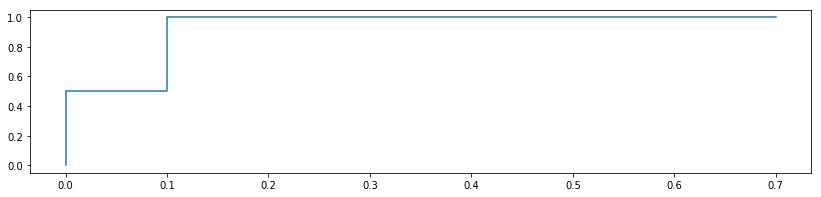

In [26]:
plt.figure(figsize=(14,3))
plt.step(tvec, yout.flatten())

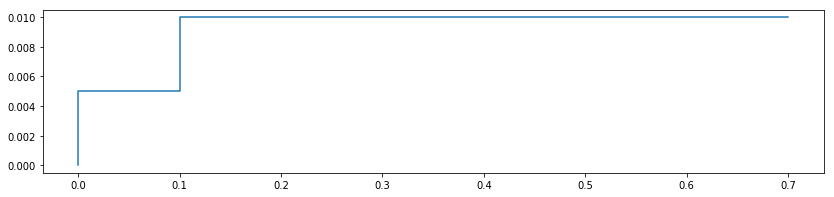

In [27]:
plt.figure(figsize=(14,3))
plt.step(tvec, yout_v.flatten())

# Exercises

## Design a less agressive controller
Consider to let the closed-loop poles be less fast. Choose something reasonable, for instance a double pole in $z=0.5$, or a pair of complex-conjugated poles in $z=0.6 \pm i0.3$. Redo the design, following the example above. Find the state feedback and simulate step-responses.

## Design a deadbeat controller for the DC-motor
From the textbook (Åström & Wittenmark) Appendix:
![title](dcmotor.png)
1. Use symbolic calculations to find the discrete-time state-space model for arbitrary sampling period $h$. 
2. Design a deadbeat controller for arbitrary sampling period.
3. Assume a disturbance is acting on the input to the system, as an unknown torque on the motor shaft. This means that the disturbance enters into the system in the same way as the disturbance on the mass on frictionless surface analyzed above. Simulate step-responses for the closed-loop system.